In [1]:
% matplotlib inline
import bayleaf as bf
import numpy as np
import pymc3 as pm
import matplotlib.pylab as plt
import theano
import theano.tensor as tt
import pandas as pd
FLOAT_EPS = np.finfo(float).eps
np.random.seed(34333823)

/anaconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Demo for Frailty Model

In [2]:
n = 65000
## generate gamma frailty according to parameters \theta^{-1}
theta = .510
## generate gamma frailty term, ~Γ(θ^{-1},θ), np parameterizes with scale, so
### In later versions of this, we merge this within the data generator
## functionalize this
β1 = np.array([0.63, 0.03])
β2 = np.array([0.8, 0.03])
β3 = np.array([0.9, 0.03])
βs = np.vstack([β1,β2,β3])
k=3
λk = np.array([0.0047, 0.0037, 0.0057])
ρk = np.array([0.716, .725, .73])

r_true = .5
r_this = .5
def sim_simple_covs(n):
    sex = np.random.binomial(n=1,p=.5,size =n)
    age = np.random.gamma(size=n,  shape = 10, scale = 1/.3)
    return(np.array([sex,age]).T)
X = sim_simple_covs(n)
# Simulate Survival Times, generalize for k categories
def sim_weibull_frail_generalized(betas, theta, X, lam, r, rho, maxtime, cens_end, n, k, first = False):
    '''
    Function to simulate transformed weibull survival times with uniform censoring according to the weibull PH model
    Parameters
    ----------
    betas : effect sizes
    lam : scale parameters for different levels (must be dimension kx1)
    theta : parameter of gamma distribution of frailties
    rho : shape parameters for each level (kx1)
    X : covariates
    maxtime : maximum study time
    r : transformation parameter
    k : number of outcomes
    first : boolean, do we want to return just the time to first event
    '''
    w = np.random.gamma(size = n, shape=theta**(-1), scale = theta)
    ## from probability integral transform
    Te = ((np.exp(-(np.log(np.random.uniform(size=(n,k)))*r)/w[:,None])-1)/(r*lam*np.exp(np.dot(X,betas.T))))**(1/rho)
    # Do we want time to first event r?
    # generate censoring time, unif and truncated by tau
    if first == True:
        Cens = 1+cens_end*np.random.uniform(size = n)
        Cens[Cens>maxtime] = maxtime
        alltimes = np.vstack((Cens,Te.T)).T
        eventType = []
        for i in range(len(w)):
            eventType.append(np.where(alltimes[i,]==np.amin(alltimes[i,]))[0][0])
        obs_t = list(np.amin(alltimes,axis = 1))
        out = pd.DataFrame(np.array([obs_t, eventType, pd.Series(X[:,[0]][:,0]),pd.Series(X[:,[1]][:,0]),w])).T
        # Clean up for the covariates
        out.columns = ["obs_t", "eventType", "sex", "age", "sim_frail"]
    else:
        Cens = 1+cens_end*np.random.uniform(size = (n,k))
        Cens[Cens>maxtime] = maxtime
        results = np.repeat(0, n)
        names_df = ["del"]
        # loop over levels
        for level in range(k):
            obs_t = np.amin(np.array([Te[:,level], Cens[:,level]]).T, axis =1) # observed time
            names_df = np.append(names_df, "time_"+str(level+1))
            delta = (Te[:,level] < Cens[:,level]) + 0 # censoring indicator
            names_df = np.append(names_df, "delta_"+str(level+1))
            results = np.vstack((results, obs_t))
            results = pd.DataFrame(np.vstack((results, delta)))
        # Names of X
        x_names = ["X_"+str(j+1) for j in np.arange(X.shape[1])]
        names_df = np.append(names_df, x_names)
        names_df = np.append(names_df, "frailty") # now add frailty
        out = pd.DataFrame(np.vstack((results, X.T, w.T)).T)
        out.columns = names_df
        out = out.iloc[:, out.columns!="del"] # get rid of extra column
    return(out)
## NOW ACTUALLY GENERATE THE DATA, this is the intitialization step
X = sim_simple_covs(n)
data = sim_weibull_frail_generalized(betas=βs,
                              theta = theta,
                              X = X,
                              lam = λk,
                              rho = ρk,
                              maxtime=300,
                              cens_end = 390,
                              r = r_true ,k=3, first=False, n=n)

In [3]:
data.head(10)

,time_1,delta_1,time_2,delta_2,time_3,delta_3,X_1,X_2,frailty
0,134.756939,1.0,58.432164,1.0,64.199447,0.0,1.0,31.819014,0.729976
1,42.319849,0.0,254.165280,0.0,45.805219,1.0,0.0,45.665823,0.517624
2,95.298354,0.0,12.437666,0.0,5.972532,1.0,0.0,42.286111,1.675335
3,300.000000,0.0,206.215040,0.0,155.732494,1.0,0.0,21.494183,0.916369
4,106.003665,0.0,27.412719,1.0,68.090550,1.0,1.0,40.687292,0.272626
5,300.000000,0.0,51.202725,1.0,300.000000,0.0,0.0,30.666874,0.228618
6,60.537471,0.0,28.087495,0.0,271.535083,0.0,1.0,19.744297,0.118339
7,7.733794,1.0,8.838422,1.0,19.753714,1.0,0.0,32.003297,1.145173
8,205.857186,0.0,300.000000,0.0,124.722063,1.0,1.0,21.724243,0.407463
9,59.222428,0.0,11.034827,1.0,300.000000,0.0,0.0,34.683112,0.553351


In [4]:
with pm.Model() as m1:
    bf.Frailty.from_formula('([time_1, time_2, time_3],[delta_1, delta_2, delta_3])~X_1+X_2-1', data = data)
    MAP_this = pm.find_MAP()

logp = -5.1164e+05, ||grad|| = 492.31: 100%|██████████| 460/460 [01:00<00:00,  7.59it/s] 


In [5]:
MAP_this

{'X_1_0': array(0.64209837),
 'X_1_1': array(0.80151497),
 'X_1_2': array(0.91014208),
 'X_2_0': array(0.02961007),
 'X_2_1': array(0.03017085),
 'X_2_2': array(0.03105068),
 'lam_0': array(0.00481094),
 'lam_0_log__': array(-5.33686175),
 'lam_1': array(0.00378348),
 'lam_1_log__': array(-5.57711119),
 'lam_2': array(0.00536859),
 'lam_2_log__': array(-5.2271904),
 'r_0': array(0.47838729),
 'r_0_log__': array(-0.73733465),
 'r_1': array(0.47053216),
 'r_1_log__': array(-0.75389096),
 'r_2': array(0.47048947),
 'r_2_log__': array(-0.75398171),
 'rho_0': array(0.71239184),
 'rho_0_log__': array(-0.33912718),
 'rho_1': array(0.71661046),
 'rho_1_log__': array(-0.33322288),
 'rho_2': array(0.73246294),
 'rho_2_log__': array(-0.31134254),
 'theta': array(0.51077045),
 'theta_log__': array(-0.671835)}

In [6]:
with pm.Model() as m2:
    bf.Frailty_FixMAP.from_formula('([time_1, time_2, time_3],[delta_1, delta_2, delta_3])~X_1+X_2-1', 
                                   data = data, MAP = MAP_this)
    MAP2 = pm.find_MAP()

Formula Call: ([time_1, time_2, time_3],[delta_1, delta_2, delta_3])~X_1+X_2-1
Dimension of Outcome Variable: 3
Covariates in Model: ['X_1', 'X_2']
Percent Censored in Each Direction:
time_1: 0.6067846153846154
time_2: 0.6296923076923078
time_3: 0.5225230769230769
Minibatch Size: False
<TensorType(float64, matrix)>


logp = -5.1164e+05, ||grad|| = 182.11: 100%|██████████| 291/291 [00:42<00:00,  6.90it/s] 


In [7]:
with pm.Model() as m3:
    bf.Frailty_FixMAP.from_formula('([time_1, time_2, time_3],[delta_1, delta_2, delta_3])~X_1+X_2-1', 
                                   data = data, MAP = MAP_this, minibatch = 20000)    
    approx = pm.fit(50000, method = pm.FullRankADVI(), start = MAP2)


Formula Call: ([time_1, time_2, time_3],[delta_1, delta_2, delta_3])~X_1+X_2-1
Dimension of Outcome Variable: 3
Covariates in Model: ['X_1', 'X_2']
Percent Censored in Each Direction:
time_1: 0.6067846153846154
time_2: 0.6296923076923078
time_3: 0.5225230769230769
Minibatch Size: 20000
<TensorType(float64, matrix)>
We're Mini batching


Average Loss = -inf: 100%|██████████| 50000/50000 [30:49<00:00, 27.03it/s]


## We can plot the evidence lower bound

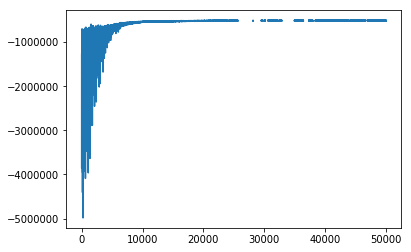

In [8]:
plt.plot(-approx.hist)

In [9]:
with m3:
    variational_trace_save = approx.sample(5000)

In [10]:
pm.summary(variational_trace_save)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
X_1_0,0.640923,0.013863,0.000199,0.614223,0.667799
X_2_0,0.028851,0.000983,0.000013,0.026968,0.030806
X_1_1,0.800977,0.014420,0.000181,0.771246,0.827920
X_2_1,0.030089,0.001237,0.000018,0.027633,0.032427
X_1_2,0.905032,0.013929,0.000182,0.879847,0.934192
X_2_2,0.030898,0.001800,0.000023,0.027172,0.034169
lam_0,0.004830,0.000154,0.000002,0.004528,0.005129
rho_0,0.712403,0.002794,0.000034,0.706605,0.717579
lam_1,0.003813,0.000093,0.000001,0.003631,0.003994
rho_1,0.716118,0.002457,0.000037,0.711351,0.720905


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2a36fa20>,
      dtype=object)

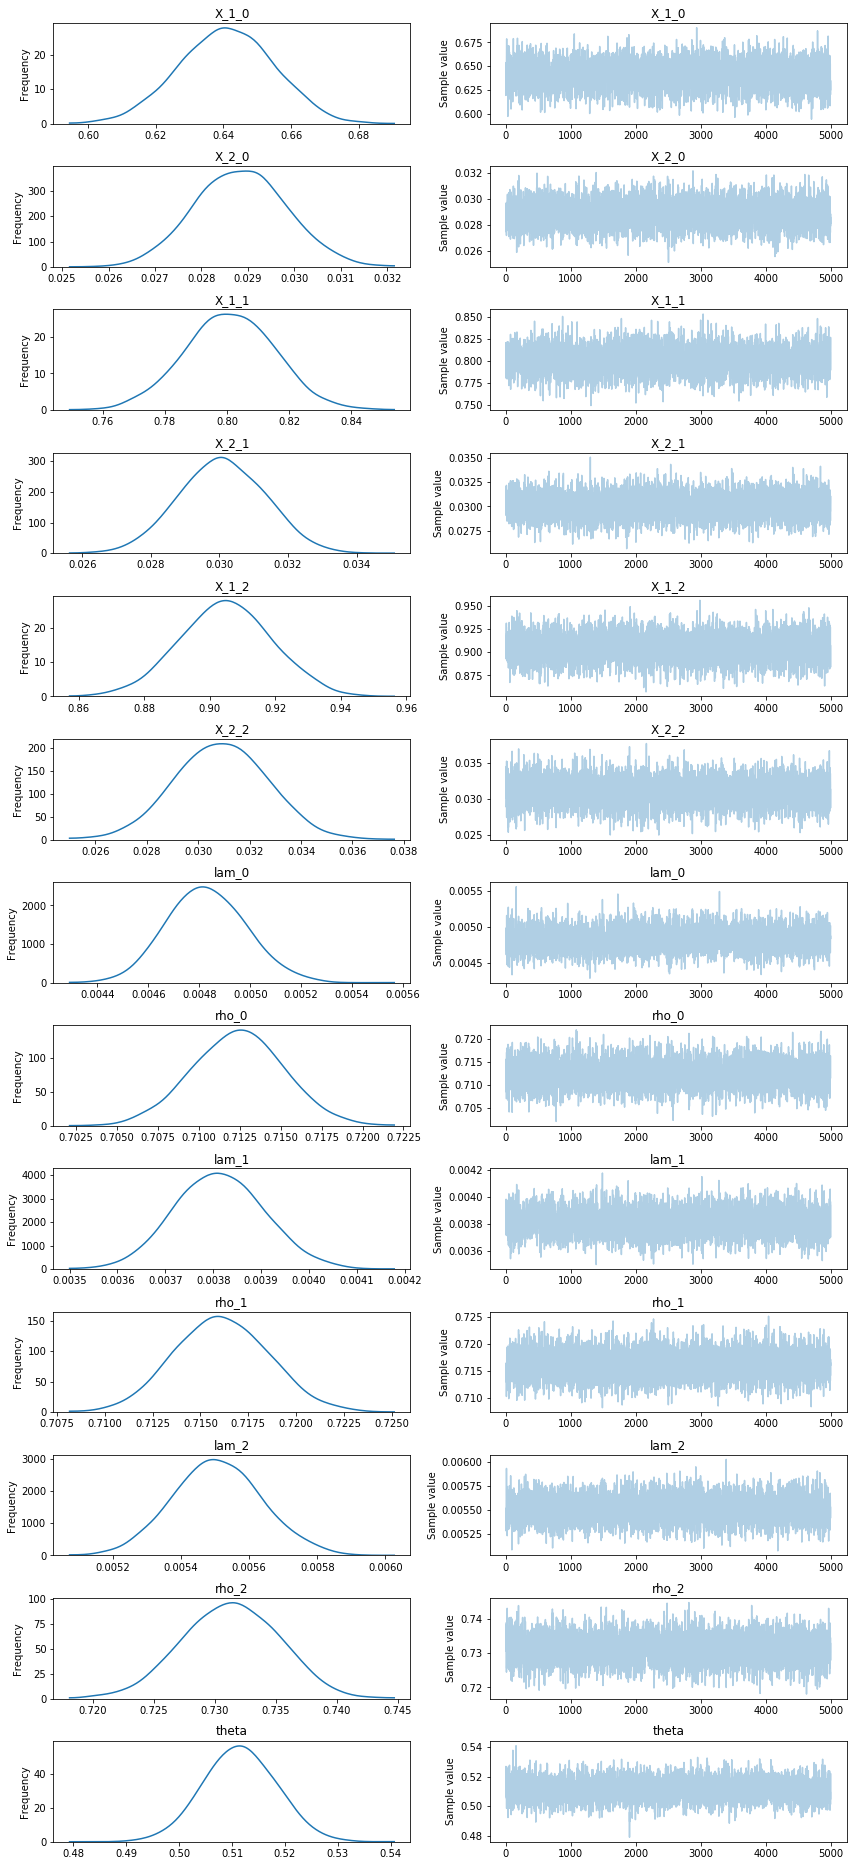

In [11]:
pm.traceplot(variational_trace_save)